In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/processed/biometria_final.csv')
le = LabelEncoder()
y = le.fit_transform(df['cow_id'])

# Seleção de colunas puramente estruturais
cols_geo = [c for c in df.columns if c.startswith('geo_')]
# Filtramos apenas HOG e LBP, ignorando color_mean e sift
cols_img_struct = [c for c in df.columns if 'img_hog_' in c or 'img_lbp_' in c]

X_geometria = df[cols_geo]
X_hibrido_struct = df[cols_geo + cols_img_struct]

print(f"📊 Geometria: {X_geometria.shape[1]} colunas")
print(f"📊 Híbrido (Geo + HOG + LBP): {X_hibrido_struct.shape[1]} colunas")

📊 Geometria: 35 colunas
📊 Híbrido (Geo + HOG + LBP): 1809 colunas


In [3]:
# Configuração do Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parâmetros para o Grid
params_mlp = {
    'classifier__hidden_layer_sizes': [(512, 256), (1024, 512), (512, 512, 256)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate': ['adaptive'],
    'classifier__solver': ['adam']
}

def executar_treino(X, y, titulo):
    print(f"\n{'='*20} {titulo} {'='*20}")
    
    # 1. Split para validação final e Matriz de Confusão
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', MLPClassifier(max_iter=1500, random_state=42))
    ])
    
    # verbose=1 mostra apenas o resumo, não todas as 90 linhas
    grid = GridSearchCV(pipe, params_mlp, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)
    
    print("⏳ Iniciando busca dos melhores parâmetros (GridSearch)...")
    grid.fit(X_train, y_train)
    
    # 2. Avaliação no conjunto de teste (dados não vistos)
    y_pred = grid.predict(X_test)
    acc_teste = accuracy_score(y_test, y_pred)
    
    print(f"\n🏆 MELHORES RESULTADOS:")
    print(f"   - Acurácia CV (Treino): {grid.best_score_:.2%}")
    print(f"   - Acurácia Real (Teste): {acc_teste:.2%}")
    print(f"   - Melhor Setup: {grid.best_params_}")
    
    # 3. Visualização dos Resultados Detalhados
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    # Gráfico A: Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=le.classes_, yticklabels=le.classes_)
    ax[0].set_title(f'Matriz de Confusão - {titulo}')
    ax[0].set_ylabel('ID Real')
    ax[0].set_xlabel('Predição')

    # Gráfico B: Curva de Perda do melhor estimador
    ax[1].plot(grid.best_estimator_.named_steps['classifier'].loss_curve_)
    ax[1].set_title('Curva de Aprendizado (Loss Curve)')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Loss')
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Relatório de texto simplificado
    print("\n📝 Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))


==================== CENÁRIO 1: Geometria Pura (Base) ====================
⏳ Iniciando busca dos melhores parâmetros (GridSearch)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

🏆 MELHORES RESULTADOS:
   - Acurácia CV (Treino): 24.00%
   - Acurácia Real (Teste): 31.67%
   - Melhor Setup: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (512, 256), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}


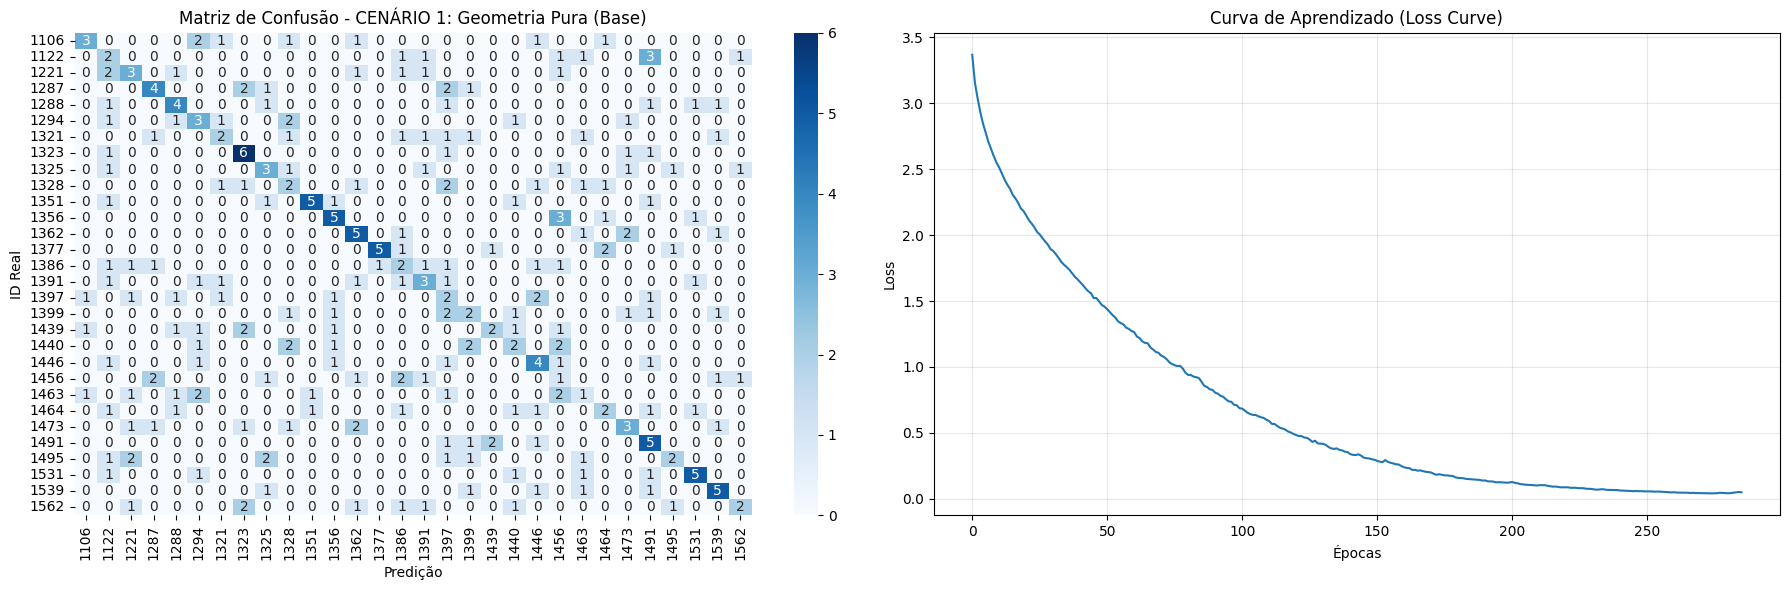


📝 Relatório de Classificação:
              precision    recall  f1-score   support

        1106       0.50      0.30      0.38        10
        1122       0.13      0.20      0.16        10
        1221       0.30      0.30      0.30        10
        1287       0.44      0.40      0.42        10
        1288       0.40      0.40      0.40        10
        1294       0.25      0.30      0.27        10
        1321       0.29      0.20      0.24        10
        1323       0.43      0.60      0.50        10
        1325       0.30      0.30      0.30        10
        1328       0.18      0.20      0.19        10
        1351       0.71      0.50      0.59        10
        1356       0.45      0.50      0.48        10
        1362       0.38      0.50      0.43        10
        1377       0.83      0.50      0.62        10
        1386       0.17      0.20      0.18        10
        1391       0.30      0.30      0.30        10
        1397       0.12      0.20      0.15       

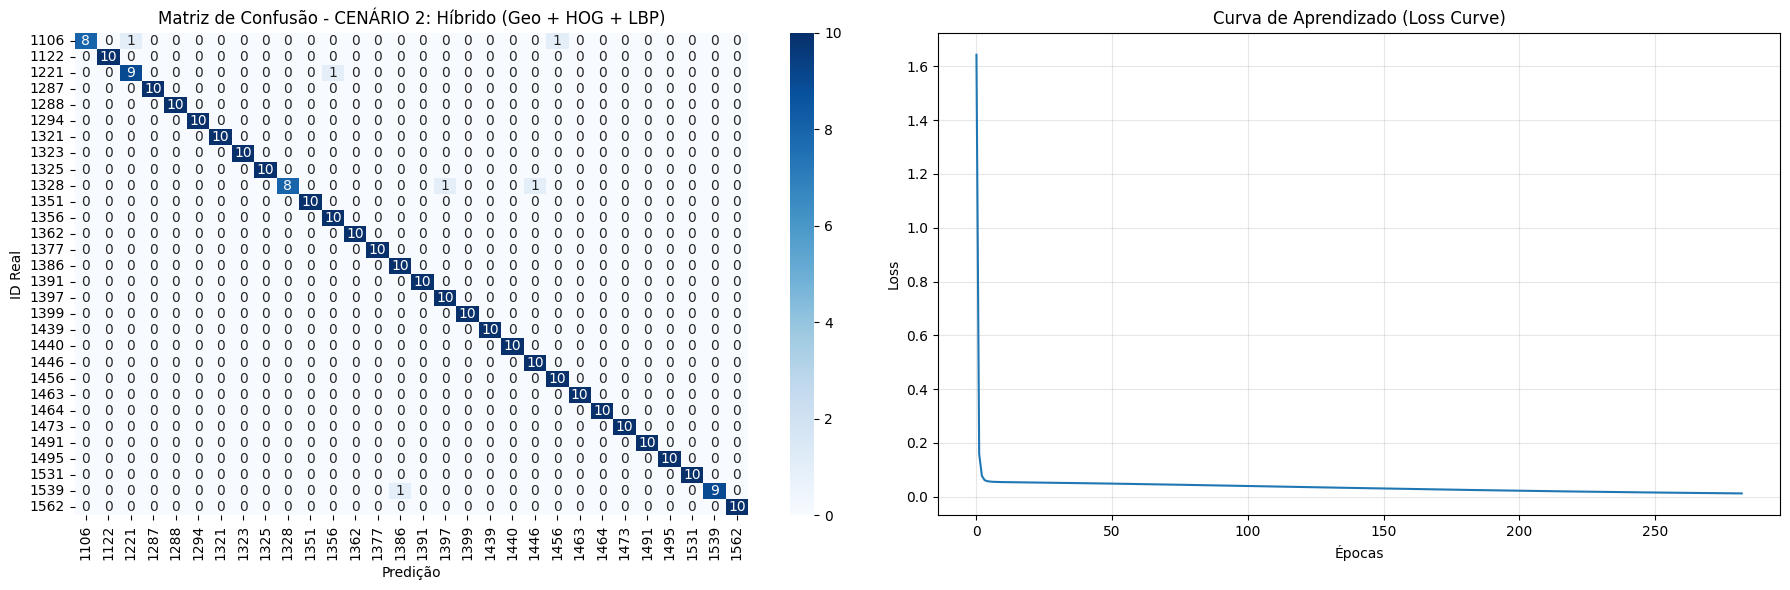


📝 Relatório de Classificação:
              precision    recall  f1-score   support

        1106       1.00      0.80      0.89        10
        1122       1.00      1.00      1.00        10
        1221       0.90      0.90      0.90        10
        1287       1.00      1.00      1.00        10
        1288       1.00      1.00      1.00        10
        1294       1.00      1.00      1.00        10
        1321       1.00      1.00      1.00        10
        1323       1.00      1.00      1.00        10
        1325       1.00      1.00      1.00        10
        1328       1.00      0.80      0.89        10
        1351       1.00      1.00      1.00        10
        1356       0.91      1.00      0.95        10
        1362       1.00      1.00      1.00        10
        1377       1.00      1.00      1.00        10
        1386       0.91      1.00      0.95        10
        1391       1.00      1.00      1.00        10
        1397       0.91      1.00      0.95       

In [4]:
executar_treino(X_geometria, y, "CENÁRIO 1: Geometria Pura (Base)")
executar_treino(X_hibrido_struct, y, "CENÁRIO 2: Híbrido (Geo + HOG + LBP)")